In [1]:
# Set the backend framework for segmentation_models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Install required libraries
!pip install patchify
!pip install -U segmentation-models
!pip install efficientnet==1.1.1

# Import necessary libraries
import cv2
import numpy as np
import random
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.utils import to_categorical
import segmentation_models as sm

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Define paths and parameters
#!dir "E:\Users\Sumit\Downloads\archive\Semantic segmentation dataset"

dataset_root_folder = "/kaggle/input/semantic-segmentation/archive/Semantic segmentation dataset"
#dataset_root_folder = "E:\\Users\\Sumit\\Downloads\\archive\\Semantic segmentation dataset"

image_patch_size = 256

# Load and preprocess the dataset
image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
    image_extension = 'jpg' if image_type == 'images' else 'png'
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            file_path = f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
            image = cv2.imread(file_path, 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image).crop((0, 0, size_x, size_y))
                image = np.array(image)

                # Patchify the image
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        individual_patch = patched_images[i, j, :, :]
                        if image_type == 'images':
                            individual_patch = MinMaxScaler().fit_transform(
                                individual_patch.reshape(-1, individual_patch.shape[-1])
                            ).reshape(individual_patch.shape)
                            image_dataset.append(individual_patch[0])
                        elif image_type == 'masks':
                            mask_dataset.append(individual_patch[0])

# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Define class colors
class_colors = {
    'water': '#3C1098',
    'land': '#8429F6',
    'road': '#6EC1E4',
    'building': '#FEDD3A',
    'vegetation': '#E2A929',
    'unlabeled': '#9B9B9B'
}

# Convert RGB masks to label masks
def rgb_to_label(mask, class_colors):
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for idx, (name, color) in enumerate(class_colors.items()):
        rgb_color = np.array(tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        label_mask[np.all(mask == rgb_color, axis=-1)] = idx
    return label_mask

# Convert all masks to label masks
labels = np.array([rgb_to_label(mask, class_colors) for mask in mask_dataset])
labels = np.expand_dims(labels, axis=-1)  # Add channel dimension

# Convert labels to categorical
total_classes = len(class_colors)
label_categorical_dataset = to_categorical(labels, num_classes=total_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, label_categorical_dataset, test_size=0.15, random_state=42
)

# Define the CNN model
def cnn_model(n_classes, image_height, image_width, image_channels):
    inputs = Input((image_height, image_width, image_channels))
    
    # Encoder (Downsampling)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Decoder (Upsampling)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax', padding='same')(x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define model parameters
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]

# Build the model
model = cnn_model(n_classes=total_classes, image_height=image_height, image_width=image_width, image_channels=image_channels)

# Define loss and metrics
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(total_classes))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Compile the model
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test)
)

# Evaluate the model
results = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss, Test IOU, Test F1 Score:", results)

results = model.evaluate(X_test, y_test, batch_size=16)
print("Validation Loss, Validation Accuracy:", results)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.0.0
    Uninstalling efficientnet-1.0.0:
      Successfully uninstalled efficientnet-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models 1.0.1 requires efficientnet==1.0.0, but you have efficientnet 1.1.1 which is incompatible.
Segmentation Models: using `tf.keras` framework.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 6)         │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,365,990 (5.21 MB)

 Trainable params: 1,365,990 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - f1-score: 0.1403 - iou_score: 0.1207 - loss: 0.8448 - val_f1-score: 0.3370 - val_iou_score: 0.2969 - val_loss: 0.7295
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - f1-score: 0.3248 - iou_score: 0.2791 - loss: 0.6897 - val_f1-score: 0.4368 - val_iou_score: 0.3701 - val_loss: 0.6639
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - f1-score: 0.4005 - iou_score: 0.3348 - loss: 0.6427 - val_f1-score: 0.5390 - val_iou_score: 0.4386 - val_loss: 0.6025
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - f1-score: 0.5067 - iou_score: 0.4051 - loss: 0.5822 - val_f1-score: 0.5984 - val_iou_score: 0.4931 - val_loss: 0.5274
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - f1-score: 0.5561 - iou_score: 0.4482 - loss: 0.5282 - val_f1-score: 0.6097 - val_iou_score: 0.5026 - val_loss: 0.5127
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - f1-score: 0.5752 - iou_score: 0.4675 - loss: 0.5062 - val_f1-score: 0.5899 - val_iou_score: 

In [2]:
model.save("/kaggle/working/satellite_mod_cnn_20epochs.hdf5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


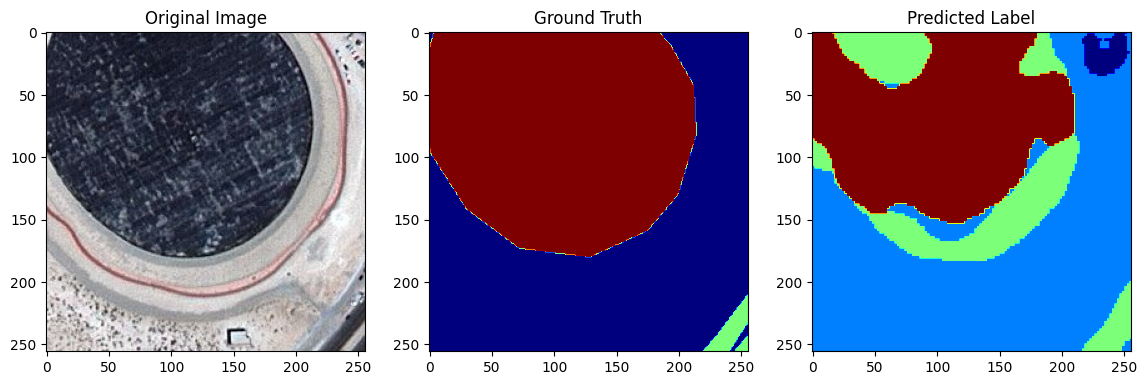

In [4]:
# Visualize predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=-1)

random_image_id = random.randint(0, len(X_test))
plt.figure(figsize=(14, 8))
plt.subplot(131)
plt.imshow(X_test[random_image_id])
plt.title("Original Image")

plt.subplot(132)
plt.imshow(np.argmax(y_test[random_image_id], axis=-1), cmap='jet')
plt.title("Ground Truth")

plt.subplot(133)
plt.imshow(predicted_labels[random_image_id], cmap='jet')
plt.title("Predicted Label")
plt.show()